# Image Classification: Detecting Pediatric Pneumonia

## Overview

## Business Understanding

## Data Understanding

## Data Preparation

In [1]:
pip install split-folders

Note: you may need to restart the kernel to use updated packages.


In [18]:
import pandas as pd 
import splitfolders
import matplotlib.pyplot as plt
import seaborn as sns


from keras.preprocessing.image import ImageDataGenerator

from keras import models
from keras import layers 
from keras import optimizers
from sklearn.dummy import DummyClassifier
from sklearn.metrics import recall_score, classification_report, precision_score
from sklearn.model_selection import cross_val_score
from keras import metrics
from tensorflow.keras.wrappers import scikit_learn
import tensorflow as tf
from tensorflow.keras.layers import Dense
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay


seed = 42
tf.random.set_seed(seed)
%matplotlib inline 

### Pre-processing

In [ ]:
#splitfolders.ratio("Data", output="Data_Split",
#    seed=42, ratio=(.64, .16, .2), group_prefix=None, move=True)

In [3]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [4]:
train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        'Data_Split/train',
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=3747,
        color_mode='grayscale',
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')


Found 3747 images belonging to 2 classes.


In [5]:
validation_generator = val_datagen.flow_from_directory('Data_Split/val',
                                                        target_size=(150, 150),
                                                        batch_size=936,
                                                        color_mode='grayscale',
                                                        class_mode='binary')
test_generator = test_datagen.flow_from_directory('Data_Split/test',
                                                  target_size=(150, 150),
                                                  batch_size=1173,
                                                  color_mode='grayscale',
                                                  class_mode='binary')

Found 936 images belonging to 2 classes.
Found 1173 images belonging to 2 classes.


In [6]:
#Creating the augumented data

aug_train_images = ImageDataGenerator(rotation_range=30, 
                                   width_shift_range=0.25, 
                                   height_shift_range=0.25, 
                                   shear_range=0.25, 
                                   zoom_range=0.25, 
                                   horizontal_flip=True,
                                   vertical_flip=True)

train_aug = aug_train_images.flow_from_directory('Data_Split/train',
                                                  target_size=(150, 150),
                                                  batch_size=3747,
                                                  color_mode='grayscale',
                                                  class_mode='binary')

Found 3747 images belonging to 2 classes.


In [7]:
#getting images and labels for models
train_data, train_labels = next (train_generator)
test_data, test_labels = next (test_generator)
val_data, val_labels = next (validation_generator)

In [8]:
#reshaping
train_data = train_data.reshape(train_data.shape[0], -1)
test_data = test_data.reshape(test_data.shape[0], -1)
val_data = val_data.reshape(val_data.shape[0], -1)
train_data.shape

(3747, 22500)

In [9]:
def metrics(history):
    
    sigmoid_loss = results.history['loss']
    sigmoid_accuracy = results.history['accuracy']

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
    sns.lineplot(x=results.epoch, y=sigmoid_loss, ax=ax1, label='loss')
    sns.lineplot(x=results.epoch, y=sigmoid_accuracy, ax=ax2, label='accuracy');

#### Dummy (baseline model)

In [10]:
dummy_model =  DummyClassifier(strategy='most_frequent')
dummy_model.fit(train_data, train_labels)

DummyClassifier(strategy='most_frequent')

In [11]:
y_preds_dummy = dummy_model.predict(val_data)

In [12]:
dummy_acc = dummy_model.score(val_data, val_labels)
dummy_rec = recall_score(val_labels,y_preds_dummy)
dummy_pre = precision_score(val_labels,y_preds_dummy)

print(f"Dummy Model accuracy: {dummy_acc}")
print(f"Dummy Model recall: {dummy_rec}")
print(f"Dummy Model precision: {dummy_pre}")

Dummy Model accuracy: 0.7297008547008547
Dummy Model recall: 1.0
Dummy Model precision: 0.7297008547008547


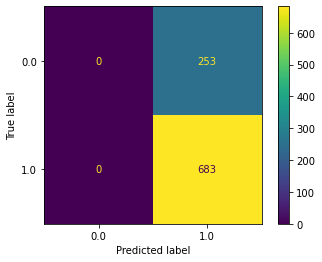

In [13]:
# Confusion matrix for dummy model
plot_confusion_matrix(dummy_model, val_data, val_labels);

#### Simple Model 1

In [19]:
simple_model = models.Sequential()

In [20]:
simple_model.add(layers.Dense(12, activation='relu', input_shape=(22500,)))
simple_model.add(layers.Dense(1, activation='sigmoid'))                       

In [22]:
simple_model.compile(optimizer='SGD',
                       loss='binary_crossentropy',
                       metrics=['accuracy', metrics.Precision(), metrics.Recall()])
simple_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 12)                270012    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 13        
Total params: 270,025
Trainable params: 270,025
Non-trainable params: 0
_________________________________________________________________


In [23]:
simple_model_fit = simple_model.fit(train_data, train_labels, epochs=10, 
                                    batch_size=32, validation_data= (val_data, val_labels), verbose=1)

Epoch 1/10
118/118 [==============================] - 2s 19ms/step - loss: 0.5431 - accuracy: 0.7216 - precision_1: 0.7313 - recall_1: 0.9777 - val_loss: 0.5326 - val_accuracy: 0.7297 - val_precision_1: 0.7297 - val_recall_1: 1.0000
Epoch 2/10
118/118 [==============================] - 1s 6ms/step - loss: 0.4097 - accuracy: 0.7699 - precision_1: 0.7704 - recall_1: 0.9755 - val_loss: 0.3925 - val_accuracy: 0.7949 - val_precision_1: 0.7825 - val_recall_1: 0.9956
Epoch 3/10
118/118 [==============================] - 1s 7ms/step - loss: 0.3481 - accuracy: 0.8751 - precision_1: 0.8820 - recall_1: 0.9568 - val_loss: 0.6029 - val_accuracy: 0.7489 - val_precision_1: 0.7440 - val_recall_1: 1.0000
Epoch 4/10
118/118 [==============================] - 1s 6ms/step - loss: 0.3208 - accuracy: 0.8938 - precision_1: 0.9033 - recall_1: 0.9568 - val_loss: 0.4966 - val_accuracy: 0.7190 - val_precision_1: 0.9976 - val_recall_1: 0.6164
Epoch 5/10
118/118 [==============================] - 1s 6ms/step - los

In [24]:
loss = simple_model_fit.history['loss']
accuracy = simple_model_fit.history['accuracy']
precision = simple_model_fit.history['precision']
recall = simple_model_fit.history['recall']

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15,8))
sns.lineplot(x=simple_model_fit.epoch, y=loss, ax=ax1, label='loss')
sns.lineplot(x=simple_model_fit.epoch, y=accuracy, ax=ax2, label='accuracy')
sns.lineplot(x=simple_model_fit.epoch, y=precision, ax=ax3, label='precision')
sns.lineplot(x=simple_model_fit.epoch, y=recall, ax=ax4, label='recall');

KeyError: 'precision'

##### Simple Model GridSearch

In [ ]:
def create_model():
    #create model
    model = models.Sequential()
    model.add(Dense(12, activation='relu', input_shape=(22500,)))
    model.add(Dense(1, activation='sigmoid'))
    #Compile model
    model.compile(loss='binary_crossentropy',
                  metrics=['accuracy', metrics.Precision(), metrics.Recall()])
    return model
  

In [ ]:
keras_model = scikit_learn.KerasClassifier(create_model, verbose=1)
batch_size = [10, 20, 30, 50, 75, 100 ]
epochs = [10, 20, 30, 40 ]
optimizer = ['SGD','ADAM']
param_grid = dict(batch_size=batch_size, epochs=epochs, optimizer=optimizer)


In [ ]:
grid = GridSearchCV(estimator= keras_model, param_grid=param_grid, cv=5)
grid_result = grid.fit(train_data, train_labels)

### Convolutional Neural Network

In [ ]:
train_data, train_labels = next (train_generator)
test_data, test_labels = next (test_generator)
val_data, val_labels = next (validation_generator)

In [ ]:
cnn_model = models.Sequential()
cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(150,150,1)))
cnn_model.add(layers.MaxPooling2D((2,2)))
cnn_model.add(layers.Conv2D(32, (3,3), activation='relu'))       
cnn_model.add(layers.MaxPooling2D((2,2)))
cnn_model.add(layers.Flatten())
cnn_model.add(Dense(12, activation='relu'))
cnn_model.add(Dense(1, activation='sigmoid'))              

In [ ]:
cnn_model.compile(optimizer='SGD',
                       loss='binary_crossentropy',
                       metrics=['accuracy', metrics.Precision(), metrics.Recall()])

In [ ]:
cnn_model_fit = cnn_model.fit(train_data, train_labels, epochs=10, 
                                    batch_size=32, validation_data= (val_data, val_labels), verbose=1)

In [ ]:
def create_model():
    #create model
    cnn_model = models.Sequential()
    cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(150,150,1)))
    cnn_model.add(layers.MaxPooling2D((2,2)))
    cnn_model.add(layers.Conv2D(32, (3,3), activation='relu'))       
    cnn_model.add(layers.MaxPooling2D((2,2)))
    cnn_model.add(layers.Flatten())
    cnn_model.add(Dense(12, activation='relu'))
    cnn_model.add(Dense(1, activation='sigmoid')) 
    #Compile model
    model.compile(optimizer='SGD', loss='binary_crossentropy',
                  metrics=['accuracy', metrics.Precision(), metrics.Recall()])
    return model

In [ ]:
cnn_model = scikit_learn.KerasClassifier(create_model, verbose=1)
batch_size = [10, 20]
epochs = [10, 25]
param_grid = dict(batch_size=batch_size, epochs=epochs)

In [ ]:
grid = GridSearchCV(estimator= cnn_model, param_grid=param_grid, cv=5)
grid_result = grid.fit(train_data, train_labels)